In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyathena as pa
import pandas as pd
import xarray as xr
import glob
import os

Reading a history file:G:/yeongu//RPS_8pc_noICM_newacc/hst/RPS_8pc_noICM_newacc.hst.p
(896L,)
4.035628029426985 4.0972840362085545
Reading a history file:G:/yeongu//RPS_8pc_ICM1_newacc/hst/RPS_8pc_ICM1_newacc.hst.p
(896L,)
4.336195679208766 4.333913591654512
Reading a history file:G:/yeongu//RPS_8pc_ICM2_newacc/hst/RPS_8pc_ICM2_newacc.hst.p
(896L,)
4.409158223726677 4.3763916961000575


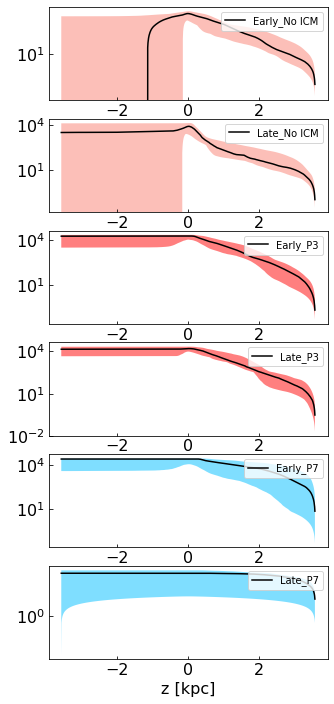

In [248]:
import astropy.constants as c
import astropy.units as u
unit=pa.set_units(muH=1.4271)

plt.rcParams['font.size']=16
import os,glob
labels=['noICM_new','ICM1_new','ICM2_new'] # ['no ICM','ICM00','ICM0']#,'ICM00','ICM0',,'ICM2','ICM3','ICM4'
ids=['RPS_8pc_noICM_newacc','RPS_8pc_ICM1_newacc','RPS_8pc_ICM2_newacc'] # RPS_8pc_ICM00','RPS_8pc_ICM0',,'RPS_8pc_ICM2','RPS_8pc_ICM3','RPS_8pc_ICM4'
#ids=['R8_8pc_metal','RPS_8pc_ICM0','RPS_8pc_ICM1','RPS_8pc_ICM2','RPS_8pc_ICM3']
base='G:/yeongu/'
#base='F:/yeongu/'
#base2='D:/yeongu/'
#C = ('darkkhaki','b','r','k','g','magenta','cyan') # 
C = ('salmon','r','deepskyblue','b','g')
C2 = ('darkblue','deepskyblue','goldenrod','red','firebrick')
hh = [0.006,0.006,0.15]
labell = ('No ICM', 'P3', 'P7')  # r'No ICM',
kb = 1.3806504 * 1e-16 #boltzmann constant erg/K / erg = g cm2/s2
meter = 3.24078*1e-17 # pc
kg = 5.02785*1e-31 # solar mass
#fig =plt.figure(figsize=(7.5,12))
k=1
crit = 94
plt.figure(figsize=(5,12))
for j,problem_id in enumerate(ids):
    #rstfiles=glob.glob('%s%s/id0/%s.????.rst' % (base,problem_id,problem_id))
    #rstfiles+=glob.glob('%s%s/rst/%s.????.rst' % (base,problem_id,problem_id))
    parfile='{}/{}/{}.par'.format(base,problem_id,problem_id)
    hstfile='{}/{}/hst/{}.hst'.format(base,problem_id,problem_id)
    hst=pa.hst_reader(hstfile)
    #print unit
    Myr=unit['time'].to('Myr').value
    #print unit['density']
    hst.index=hst.time
    hst=hst.loc[250:500,:]
    hst.index=hst.time*Myr
    
    sfr= hst.sfr10
    
    par=pa.get_params(parfile)
    
    Lx=par['x1max']-par['x1min']
    Ly=par['x2max']-par['x2min']
    Lz=par['x3max']-par['x3min']
    
    plist=['phase1','phase2','phase3','phase4','phase5']
    datasets = xr.Dataset()
    for phase in plist:
        path='{}{}/zprof_merged/{}.{}.zprof.nc'.format(base,problem_id,problem_id,phase)
        with xr.open_dataarray(path) as da: da.load()
        #print da
        datasets[phase]=da
    zprof_ds=datasets
    zprof_ds = zprof_ds.sel(taxis=slice(250,500))
    #print zprof_ds.fields
    cold = (zprof_ds['phase1']+zprof_ds['phase2']+zprof_ds['phase3']).loc['d']
    Munit=(unit['density']*unit['velocity']*unit['time']).to('Msun/pc^2').value
    #print zprof_ds['phase1'].loc['A'].data.cumsum(), zprof_ds['phase2'].loc['A']
    zprof = zprof_ds.to_array().sum(dim='variable')
    #print '------------------------'
    #print zprof.loc['d']
    #print zprof.loc['ge']
    #print unit['gravitational_potential']
    #phiex = zprof.loc['Phie'].data*unit['gravitational_potential']/(1024*1024)
    #print zprof.loc['Phie'].data/(1024*1024)#*unit['gravitational_potential'].cgs
    dWsg = zprof.loc['dWsg'].data/(1024*1024)
    dWext = zprof.loc['dWext'].data/(1024*1024)
    gext = zprof.loc['gext'].data/(1024.*1024)#*(3.24*1e-14) # km/s^2
    gsg = zprof.loc['gsg'].data/(1024.*1024)#*(3.24*1e-14)
    #print dWsg, gsg, zprof.loc['Phie'].data/(1024*1024)
    d = zprof.loc['d'].data*unit['density']/(1024.*1024)*(6.767e-8)#*(8*8*8) # solar mass / pc3 to g / km3
    #print zprof.loc['d']*unit['density']/(1024.*1024)
    #print d.max(), d.min()
    #d = zprof.loc['d'][:,0].data*unit['density']*(8*8*8)
    #print np.sum(d)/(1024*1024*8)
    z = zprof.zaxis/1000.
    #plt.plot(z,phiex)
    #plt.plot(z,gext)
    #plt.plot(z,gsg)
    #plt.plot(z,d)
    Tot_e=[]
    Tot_l=[]
    
    if j!=4:
        tt=249
    else:
        tt=224
    print dWext[:,0].shape
    for i in range(tt):
        #plt.plot(z,(d*gext)[:,i],c='r',label='External')
        #plt.plot(z,(d*gsg)[:,i],c='g',label='Self')
        ext = (dWext)[:,i][::-1].cumsum()[::-1]*8*8*8#/kb#/(1e-10)#/(1e11)#*(2e-9)
        sel = (dWsg)[:,i][::-1].cumsum()[::-1]*8*8*8#/kb#/(1e-10)#/(1e11)#*(2e-9)
        tot = ext + sel
        
        if i < crit:
            Tot_e.append(tot)
        else:
            Tot_l.append(tot)
            
    Tot_e = np.array(Tot_e); Tot_l=np.array(Tot_l)
    Medi_e = np.median(Tot_e,axis=0); Medi_l = np.median(Tot_l,axis=0)
    Min_e = np.min(Tot_e,axis=0); Min_l = np.min(Tot_l,axis=0)
    Max_e = np.max(Tot_e,axis=0); Max_l = np.max(Tot_l,axis=0)
    print np.log10(np.max(Max_e)), np.log10(np.max(Max_l))
    
##################### Plot #############################

    plt.subplot(6,1,2*k-1)
    plt.plot(z,Medi_e,'k-',label='Early_%s' % labell[j])
    plt.fill_between(z,Min_e,Max_e,facecolor=C[j],alpha=0.5)

    #plt.xticks([73 * 8, 198 * 8, 323 * 8, 448 * 8, 573 * 8, 698 * 8, 823 * 8], [])
    #plt.ylabel(r'Pressure $[K cm^{-3}]$')
    plt.yscale('log', nonposy='clip')
    #plt.ylim(1e3, 2e5)
    #plt.xlim(0, 7168)
    plt.tick_params(which='major', direction='in')
    plt.tick_params(which='minor', direction='in')
    plt.legend(loc='upper right',fontsize=10)

    plt.subplot(6,1,2*k)
    plt.plot(z,Medi_l,'k-',label='Late_%s' % labell[j])
    plt.fill_between(z,Min_l,Max_l,facecolor=C[j],alpha=0.5)

    #plt.xticks([73 * 8, 198 * 8, 323 * 8, 448 * 8, 573 * 8, 698 * 8, 823 * 8], ['-3', '-2', '-1', '0', '1', '2', '3'])
    #plt.ylabel(r'Pressure $[K cm^{-3}]$')
    if k==3:
        plt.xlabel(r'z [kpc]')
    plt.yscale('log', nonposy='clip')
    #plt.ylim(1e3, 2e5)
    #plt.xlim(0,7168)
    plt.tick_params(which='major', direction='in')
    plt.tick_params(which='minor', direction='in')
    plt.legend(loc='upper right',fontsize=10)

    k=k+1 

#plt.tight_layout()
#plt.savefig('D:/yeongu/plots/paperplot/new/Press_range_w_mag_all.png')
plt.show()
    


Reading a history file:G:/yeongu//RPS_8pc_noICM_newacc/hst/RPS_8pc_noICM_newacc.hst.p


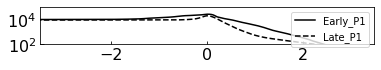

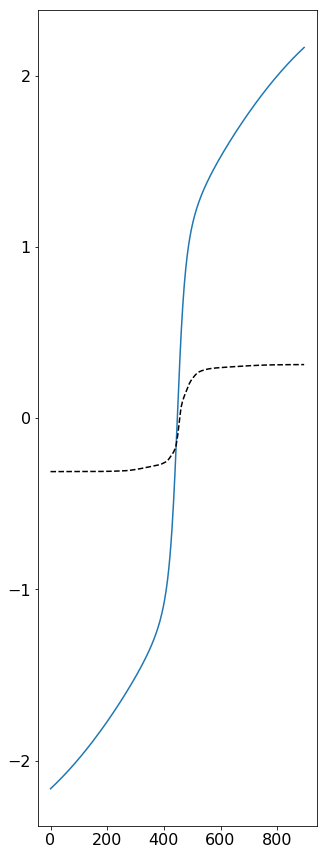

19835.51798930646 19207.0292562 solMass / pc3
Reading a history file:G:/yeongu//RPS_8pc_ICM0_newacc/hst/RPS_8pc_ICM0_newacc.hst.p


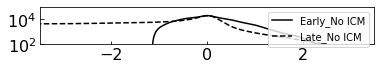

25668.72925324694 19136.3492918 solMass / pc3


KeyboardInterrupt: 

In [4]:
import astropy.constants as c
import astropy.units as u
unit=pa.set_units(muH=1.4271)

plt.rcParams['font.size']=16
import os,glob
labels=['noICM_new','ICM1_new','ICM2_new'] # ['no ICM','ICM00','ICM0']#,'ICM00','ICM0',,'ICM2','ICM3','ICM4'
ids=['RPS_8pc_noICM_newacc','RPS_8pc_ICM0_newacc','RPS_8pc_ICM1_newacc','RPS_8pc_ICM2_newacc','RPS_8pc_ICM3_newacc'] # RPS_8pc_ICM00','RPS_8pc_ICM0',,'RPS_8pc_ICM2','RPS_8pc_ICM3','RPS_8pc_ICM4'
#ids=['R8_8pc_metal','RPS_8pc_ICM0','RPS_8pc_ICM1','RPS_8pc_ICM2','RPS_8pc_ICM3']
base='G:/yeongu/'
#base='F:/yeongu/'
#base2='D:/yeongu/'
#C = ('darkkhaki','b','r','k','g','magenta','cyan') # 
C = ('salmon','r','deepskyblue','b','g')
C2 = ('darkblue','deepskyblue','goldenrod','red','firebrick')
hh = [0.006,0.006,0.15]
labell = ('No ICM','P1', 'P3', 'P7','P14')  # r'No ICM',
kb = 1.3806504 * 1e-16 #boltzmann constant erg/K / erg = g cm2/s2
cm = 3.24078*1e-19 # pc
gram = 5.02785*1e-34 # solar mass
#fig =plt.figure(figsize=(7.5,12))
k=1
crit = 94
plt.figure(figsize=(5,15))
for j,problem_id in enumerate(ids):
    #rstfiles=glob.glob('%s%s/id0/%s.????.rst' % (base,problem_id,problem_id))
    #rstfiles+=glob.glob('%s%s/rst/%s.????.rst' % (base,problem_id,problem_id))
    parfile='{}/{}/{}.par'.format(base,problem_id,problem_id)
    hstfile='{}/{}/hst/{}.hst'.format(base,problem_id,problem_id)
    hst=pa.hst_reader(hstfile)
    #print unit
    Myr=unit['time'].to('Myr').value
    #print unit['density']
    hst.index=hst.time
    hst=hst.loc[250:500,:]
    hst.index=hst.time*Myr
    
    sfr= hst.sfr10
    
    par=pa.get_params(parfile)
    
    Lx=par['x1max']-par['x1min']
    Ly=par['x2max']-par['x2min']
    Lz=par['x3max']-par['x3min']
    
    plist=['phase1','phase2','phase3','phase4','phase5'] # choose cold unstable warm 
    datasets = xr.Dataset()
    for phase in plist:
        path='{}{}/zprof_merged/{}.{}.zprof.nc'.format(base,problem_id,problem_id,phase)
        with xr.open_dataarray(path) as da: da.load()
        #print da
        datasets[phase]=da
    zprof_ds=datasets
    zprof_ds = zprof_ds.sel(taxis=slice(250,500))
    #print zprof_ds.fields

    Munit=(unit['density']*unit['velocity']*unit['time']).to('Msun/pc^2').value
    #print zprof_ds['phase1'].loc['A'].data.cumsum(), zprof_ds['phase2'].loc['A']
    zprof = zprof_ds.to_array().sum(dim='variable') # three phase sum
    #print '------------------------'
    #print zprof.loc['d']
    #print zprof.loc['ge']
    #print unit['gravitational_potential']
    #phiex = zprof.loc['Phie'].data*unit['gravitational_potential']/(1024*1024)
    #print zprof.loc['Phie'].data/(1024*1024)#*unit['gravitational_potential'].cgs
    Area = 1024*1024.
    Area2 = zprof.loc['A']
    #print Area2
    #Area = 1024*1024.
    #print Area.shape
    #Phie = (zprof.loc['Phie']/Area).data # km2/s2
    #Phisg = (zprof.loc['Phisg']/Area2).data # km2/s2
    #dWext = (zprof.loc['dWext']/Area).data
    #print dWext
    #dWsg = (zprof.loc['dWsg']/Area).data
    gext = np.nan_to_num((zprof.loc['gext']/Area).data)#*(3.24*1e-14) # km/s^2
    
    gsg = np.nan_to_num((zprof.loc['gsg']/Area).data)#*(3.24*1e-14)
    #plt.plot(Phisg[:,0])
    #gsg2 = np.gradient(Phisg[:,0],8)
    #plt.plot(gsg2*Area2[:,0]/Area)
    #plt.plot(dWext[:,0][::-1].cumsum()[::-1])
    plt.plot(gext[:,0])
    plt.plot(gsg[:,0],'k--')
    plt.show()
    #print dWsg, gsg, zprof.loc['Phie'].data/(1024*1024)
    #Area = 1024*1024.
    #Area = zprof.loc['A']
    d = np.nan_to_num((zprof.loc['d']/Area).data*unit['density'])
    #plt.plot(d[:,0])
    #plt.show()
    #d = zprof.loc['d'].data*unit['density']/(1024.*1024)#*(6.767e-8)#*(8*8*8) # solar mass / pc3 to g / km3

    #print d.max(), d.min()
    #d = zprof.loc['d'][:,0].data*unit['density']*(8*8*8)
    #print np.sum(d)/(1024*1024*8)
    z = zprof.zaxis/1000.
    #plt.plot(z,phiex)
    #plt.plot(z,Phie)
    #plt.plot(z,Phisg)
    #plt.show()
    #plt.plot(z,d)

    
    if j!=4:
        tt=249
    else:
        tt=224
    #print dWext[:,0].shape
    #print np.shape(gext)
    Ext = (np.cumsum((gext/(3.086e13)**2*d/kb)[::-1,:],axis=0)[::-1,:]*cm*8/gram)
    Sg = (np.cumsum((gsg/(3.086e13)**2*d/kb)[::-1,:],axis=0)[::-1,:]*cm*8/gram)
    #plt.plot(Ext[:,0])
    #plt.plot(Sg[:,0])
    #plt.show()
    '''
    for i in range(tt):
        #plt.plot(z,(d*gext)[:,i],c='r',label='External')
        #plt.plot(z,(d*gsg)[:,i],c='g',label='Self')
        ext = (gext[:,i]/(3.086e13)**2*d[:,i]/kb)[::-1].cumsum()[::-1]*cm*8/gram
        sg = (gsg[:,i]/(3.086e13)**2*d[:,i]/kb)[::-1].cumsum()[::-1]*cm*8/gram
        tot = ext + sg
        Ext.append(ext)
        Sg.append(sg)
        if i < crit:
            Tot_e.append(tot)
        else:
            Tot_l.append(tot)
    '''
    Tot = Ext + Sg
    Tot_e = Tot[:,0:crit]
    Tot_l = Tot[:,crit::]
    #Tot_e = np.array(Tot_e); Tot_l=np.array(Tot_l)
    #for i in range(crit):
    #    plt.plot(Tot_l[i])
    #plt.show()
    #print Tot_e
    #print Tot_l
    Sg = np.nanmedian(Sg,axis=1); Ext = np.nanmedian(Ext,axis=1)
    Medi_e = np.nanmedian(Tot_e,axis=1); Medi_l = np.nanmean(Tot_l,axis=1)
    #print Medi_e
    #print np.log10(np.nanmax(Medi_e)), np.log10(np.nanmax(Medi_l))
    Min_e = np.nanpercentile(Tot_e,25,axis=0); Min_l = np.nanpercentile(Tot_l,25,axis=0)
    
    #print np.log10(np.nanmin(Min_e)), np.log10(np.nanmin(Min_l))
    Max_e = np.nanpercentile(Tot_e,75,axis=0); Max_l = np.nanpercentile(Tot_l,75,axis=0)
    
    #print np.log10(np.nanmax(Max_e)), np.log10(np.nanmax(Max_l))
    
##################### Plot #############################

    plt.subplot(5,1,k)
    #plt.plot(z,Sg,'b-',label='sg_%s' % labell[j])
    #plt.plot(z,Ext,'r-',label='ext_%s' % labell[j])
    plt.plot(z,Medi_e,'k-',label='Early_%s' % labell[j])
    plt.plot(z,Medi_l,'k--',label='Late_%s' % labell[j])
    print np.nanmax(Medi_e), np.nanmax(Medi_l)
    #plt.fill_between(z,Min_e,Max_e,facecolor=C[j],alpha=0.5)

    #plt.xticks([73 * 8, 198 * 8, 323 * 8, 448 * 8, 573 * 8, 698 * 8, 823 * 8], [])
    #plt.ylabel(r'Pressure $[K cm^{-3}]$')
    plt.yscale('log', nonposy='clip')
    plt.ylim(1e2, 1e6)
    plt.xlim(-3.5, 3.5)
    plt.tick_params(which='major', direction='in')
    plt.tick_params(which='minor', direction='in')
    plt.legend(loc='upper right',fontsize=10)

    
    
    #plt.fill_between(z,Min_l,Max_l,facecolor=C[j],alpha=0.5)

    #plt.xticks([73 * 8, 198 * 8, 323 * 8, 448 * 8, 573 * 8, 698 * 8, 823 * 8], ['-3', '-2', '-1', '0', '1', '2', '3'])
    #plt.ylabel(r'Pressure $[K cm^{-3}]$')
    if k==3:
        plt.xlabel(r'z [kpc]')
    plt.yscale('log', nonposy='clip')
    plt.ylim(1e2, 1e5)
    plt.xlim(-3.5,3.5)
    plt.tick_params(which='major', direction='in')
    plt.tick_params(which='minor', direction='in')
    plt.legend(loc='upper right',fontsize=10)

    k=k+1 

#plt.tight_layout()
#plt.savefig('D:/yeongu/plots/paperplot/new/Weight_all_phase_quartile.png')
plt.show()
    

    


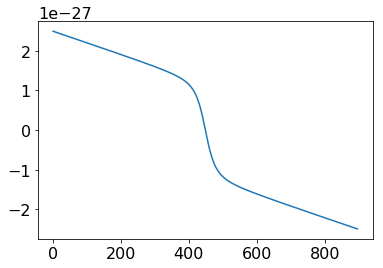

In [11]:
z = np.arange(-3588,3588,8)
#print z
d = d*2e33 # unti : gram /pc3
msol = 2e33 # gram / solar mass
g = 4.5181 * 1e-30 # gravitational constant : pc3/solmass*s2
sig_star = 42 # solmass/pc2
z_s = 245 # pc
r_0 = 8000 # pc
rho_dm = 0.0064 # solmass/pc3
pc = 3.086e13 # km / pc
g_ext = -(2.*np.pi*g*sig_star*(z)/((z)**2+z_s**2)**(0.5) + 4.*np.pi*g*rho_dm*((z)/(1+(z)**2/r_0**2))) # pc / s2
phi_ext = 2*np.pi*g*sig_star*(np.sqrt((z)**2+z_s**2)-z_s)+2*np.pi*g*rho_dm*r_0**2*np.log(1+(z)**2/r_0**2) # pc2 / s2

plt.plot(g_ext)#[::-1].cumsum()[::-1])
#plt.plot(phi_ext*pc**2)
plt.show()

Reading a history file:G:/yeongu//RPS_8pc_noICM_newacc/hst/RPS_8pc_noICM_newacc.hst.p
[[4.28897353e+17 4.28897353e+17 4.28897353e+17 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.74800439e+17 4.74800439e+17 4.74800439e+17 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.30055993e+17 5.30055993e+17 5.30055993e+17 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [2.13868046e+18 2.13962283e+18 2.14060275e+18 ... 4.02328106e+15
  2.69781401e+15 1.34660702e+15]
 [2.23698371e+18 2.23757172e+18 2.23818349e+18 ... 4.27316881e+15
  2.87613427e+15 1.45642545e+15]
 [2.28540504e+18 2.28588091e+18 2.28636581e+18 ... 4.70515799e+15
  3.16732828e+15 1.58182593e+15]]
Reading a history file:G:/yeongu//RPS_8pc_ICM1_newacc/hst/RPS_8pc_ICM1_newacc.hst.p
[[2.89798034e+18 2.89798034e+18 2.89798034e+18 ... 1.24224993e+16
  8.20067516e+15 4.06371484e+15]
 [2.90119318e+18 2.90119318e+18 2.90119318e+18 ... 1.21720505e+16
  8.01334922e+15 3.96611135e+15]
 [2.90388509e+18 2.90388509e+18 

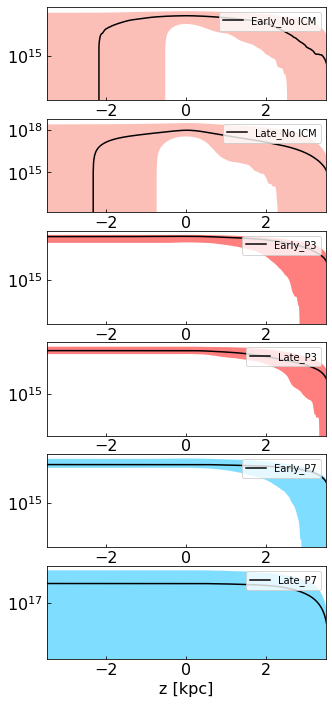

In [86]:
import astropy.constants as c
import astropy.units as u
unit=pa.set_units(muH=1.4271)

plt.rcParams['font.size']=16
import os,glob
labels=['noICM_new','ICM1_new','ICM2_new'] # ['no ICM','ICM00','ICM0']#,'ICM00','ICM0',,'ICM2','ICM3','ICM4'
ids=['RPS_8pc_noICM_newacc','RPS_8pc_ICM1_newacc','RPS_8pc_ICM2_newacc'] # RPS_8pc_ICM00','RPS_8pc_ICM0',,'RPS_8pc_ICM2','RPS_8pc_ICM3','RPS_8pc_ICM4'
#ids=['R8_8pc_metal','RPS_8pc_ICM0','RPS_8pc_ICM1','RPS_8pc_ICM2','RPS_8pc_ICM3']
base='G:/yeongu/'
#base='F:/yeongu/'
#base2='D:/yeongu/'
#C = ('darkkhaki','b','r','k','g','magenta','cyan') # 
C = ('salmon','r','deepskyblue','b','g')
C2 = ('darkblue','deepskyblue','goldenrod','red','firebrick')
hh = [0.006,0.006,0.15]
labell = ('No ICM', 'P3', 'P7')  # r'No ICM',
kb = 1.3806504 * 1e-16 #boltzmann constant erg/K / erg = g cm2/s2
cm = 3.24078*1e-19 # pc
gram = 5.02785*1e-34 # solar mass
#fig =plt.figure(figsize=(7.5,12))
k=1
crit = 94
plt.figure(figsize=(5,12))
for j,problem_id in enumerate(ids):
    #rstfiles=glob.glob('%s%s/id0/%s.????.rst' % (base,problem_id,problem_id))
    #rstfiles+=glob.glob('%s%s/rst/%s.????.rst' % (base,problem_id,problem_id))
    parfile='{}/{}/{}.par'.format(base,problem_id,problem_id)
    hstfile='{}/{}/hst/{}.hst'.format(base,problem_id,problem_id)
    hst=pa.hst_reader(hstfile)
    #print unit
    Myr=unit['time'].to('Myr').value
    #print unit['density']
    hst.index=hst.time
    hst=hst.loc[250:500,:]
    hst.index=hst.time*Myr
    
    sfr= hst.sfr10
    
    par=pa.get_params(parfile)
    
    Lx=par['x1max']-par['x1min']
    Ly=par['x2max']-par['x2min']
    Lz=par['x3max']-par['x3min']
    
    plist=['phase1','phase2','phase3'] # choose cold unstable warm 
    datasets = xr.Dataset()
    for phase in plist:
        path='{}{}/zprof_merged/{}.{}.zprof.nc'.format(base,problem_id,problem_id,phase)
        with xr.open_dataarray(path) as da: da.load()
        #print da
        datasets[phase]=da
    zprof_ds=datasets
    zprof_ds = zprof_ds.sel(taxis=slice(250,500))
    #print zprof_ds.fields

    Munit=(unit['density']*unit['velocity']*unit['time']).to('Msun/pc^2').value
    #print zprof_ds['phase1'].loc['A'].data.cumsum(), zprof_ds['phase2'].loc['A']
    zprof = zprof_ds.to_array().sum(dim='variable') # three phase sum
    #print '------------------------'
    #print zprof.loc['d']
    #print zprof.loc['ge']
    #print unit['gravitational_potential']
    #phiex = zprof.loc['Phie'].data*unit['gravitational_potential']/(1024*1024)
    #print zprof.loc['Phie'].data/(1024*1024)#*unit['gravitational_potential'].cgs
    #Area = zprof.loc['A']
    Area = 1024.*1024
    #print Area.shape
    #Phie = (zprof.loc['Phie']/Area).data # km2/s2
    #Phisg = (zprof.loc['Phisg']/Area).data # km2/s2
    #dWext = (zprof.loc['dWext']/Area).data
    #print dWext
    #dWsg = (zprof.loc['dWsg']/Area).data
    gext = (zprof.loc['gext']/Area).data#*(3.24*1e-14) # km/s^2
    gsg = (zprof.loc['gsg']/Area).data#*(3.24*1e-14)
    #plt.plot(gext[:,20])
    #plt.plot(gsg[:,20],ls='--')
    #plt.show()
    #print dWsg, gsg, zprof.loc['Phie'].data/(1024*1024)
    d = (zprof.loc['d']/Area).data*unit['density']
    #d = zprof.loc['d'].data*unit['density']/(1024.*1024)#*(6.767e-8)#*(8*8*8) # solar mass / pc3 to g / km3
    '''
    #print zprof.loc['d']*unit['density']/(1024.*1024)
    #print dWsg[:,3]/((gsg*d)[:,3].cumsum())
    t=10
    
    #plt.plot(dWsg[:,t]*8*8*4,c='magenta')
    #plt.plot(dWext[:,t]*8*8*4,c='magenta',ls='--')
    #plt.plot((dWext[:,t]+dWsg[:,t])[::-1].cumsum()[::-1],c='magenta',ls='-.')
    
    #plt.plot(Phisg[:,t],c='r')
    #plt.plot(Phie[:,t],c='r',ls='--')
    #plt.plot(Phisg[:,t]+Phie[:,t],c='g')
    
    plt.semilogy((gsg[:,t]/(3.086e13)**2*d[:,t]/kb)[::-1].cumsum()[::-1]*cm*8/gram,c='b') # km
    plt.semilogy((gext[:,t]/(3.086e13)**2*d[:,t]/kb)[::-1].cumsum()[::-1]*cm*8/gram,c='b',ls='--')
    plt.semilogy((gsg[:,t]/(3.086e13)**2*d[:,t]/kb+gext[:,t]/(3.086e13)**2*d[:,t]/kb)[::-1].cumsum()[::-1]*cm*8/gram,c='r')
    
    #plt.plot((dWext[:,t]+dWsg[:,t])/(gsg[:,t]*d[:,t]+gext[:,t]*d[:,t]))
    #plt.plot((dWext[:,t]+dWsg[:,t])[::-1].cumsum()[::-1]/(gsg[:,t]*d[:,t]+gext[:,t]*d[:,t])[::-1].cumsum()[::-1],c='b')
    #plt.plot(Phisg[:,3]/gsg[:,3],c='k')
    #print (Phisg[:,3]/gsg[:,3])
    #plt.plot(dWext[:,0]/(gext*d)[:,3],c='r')
    #plt.plot((abs((gext*d)[:,0])-abs(dWext[:,0])))
    #plt.plot(((gsg*d)[:,0][::-1].cumsum()[::-1]),c='g',ls='--')
    #z = zprof.zaxis/1000.
    #plt.semilogy(z,(gsg[:,t]*d[:,t]*8+gext[:,t]*d[:,t]*8)[::-1].cumsum()[::-1],c='purple')
    #plt.semilogy(z,(dWext[:,t][::-1].cumsum()[::-1]+dWsg[:,t][::-1].cumsum()[::-1])*8,c='b',ls='--')
    #plt.xlim(-3.5,3.5)
    #plt.ylim(-10,10)
    #plt.semilogy(dWsg[:,3].cumsum()/((gsg*d)[:,3].cumsum()))
    #plt.semilogy(dWext[:,3].cumsum()/((gext*d)[:,3].cumsum()))
    #plt.plot(dWsg[:,3])
    #plt.plot((gsg*d)[:,3])
    #plt.ylim(-2,2)
    #plt.show()
    '''
    #print d.max(), d.min()
    #d = zprof.loc['d'][:,0].data*unit['density']*(8*8*8)
    #print np.sum(d)/(1024*1024*8)
    z = zprof.zaxis/1000.
    #plt.plot(z,phiex)
    #plt.plot(z,gext)
    #plt.plot(z,gsg)
    #plt.plot(z,d)
    Tot_e=[]
    Tot_l=[]
    
    if j!=4:
        tt=249
    else:
        tt=224
    #print dWext[:,0].shape
    
    for i in range(tt):
        #plt.plot(z,(d*gext)[:,i],c='r',label='External')
        #plt.plot(z,(d*gsg)[:,i],c='g',label='Self')
        ext = (gext[:,i])[::-1].cumsum()[::-1]*cm*8/gram
        sg = (gsg[:,i])[::-1].cumsum()[::-1]*cm*8/gram
        tot = ext + sg

        if i < crit:
            Tot_e.append(tot)
        else:
            Tot_l.append(tot)
            
    Tot_e = np.array(Tot_e); Tot_l=np.array(Tot_l)
    #for i in range(crit):
    #    plt.plot(Tot_l[i])
    #plt.show()
    #print Tot_e
    print Tot_l
    Medi_e = np.median(Tot_e,axis=0); Medi_l = np.mean(Tot_l,axis=0)
    #print Medi_e
    #print np.log10(np.nanmax(Medi_e)), np.log10(np.nanmax(Medi_l))
    Min_e = np.nanmin(Tot_e,axis=0); Min_l = np.nanmin(Tot_l,axis=0)
    
    #print np.log10(np.nanmin(Min_e)), np.log10(np.nanmin(Min_l))
    Max_e = np.nanmax(Tot_e,axis=0); Max_l = np.nanmax(Tot_l,axis=0)
    
    #print np.log10(np.nanmax(Max_e)), np.log10(np.nanmax(Max_l))
    
##################### Plot #############################

    plt.subplot(6,1,2*k-1)
    plt.plot(z,Medi_e,'k-',label='Early_%s' % labell[j])
    plt.fill_between(z,Min_e,Max_e,facecolor=C[j],alpha=0.5)

    #plt.xticks([73 * 8, 198 * 8, 323 * 8, 448 * 8, 573 * 8, 698 * 8, 823 * 8], [])
    #plt.ylabel(r'Pressure $[K cm^{-3}]$')
    plt.yscale('log', nonposy='clip')
    #plt.ylim(1e3, 2e5)
    plt.xlim(-3.5, 3.5)
    plt.tick_params(which='major', direction='in')
    plt.tick_params(which='minor', direction='in')
    plt.legend(loc='upper right',fontsize=10)

    plt.subplot(6,1,2*k)
    plt.plot(z,Medi_l,'k-',label='Late_%s' % labell[j])
    plt.fill_between(z,Min_l,Max_l,facecolor=C[j],alpha=0.5)

    #plt.xticks([73 * 8, 198 * 8, 323 * 8, 448 * 8, 573 * 8, 698 * 8, 823 * 8], ['-3', '-2', '-1', '0', '1', '2', '3'])
    #plt.ylabel(r'Pressure $[K cm^{-3}]$')
    if k==3:
        plt.xlabel(r'z [kpc]')
    plt.yscale('log', nonposy='clip')
    #plt.ylim(1e3, 2e5)
    plt.xlim(-3.5,3.5)
    plt.tick_params(which='major', direction='in')
    plt.tick_params(which='minor', direction='in')
    plt.legend(loc='upper right',fontsize=10)

    k=k+1 

#plt.tight_layout()
#plt.savefig('D:/yeongu/plots/paperplot/new/Press_range_w_mag_all.png')
plt.show()
    

    


Reading a history file:G:/yeongu//RPS_8pc_noICM_newacc/hst/RPS_8pc_noICM_newacc.hst.p
10162.273847075228 11779.045995640303


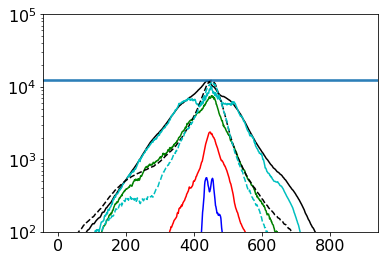

Reading a history file:G:/yeongu//RPS_8pc_ICM0_newacc/hst/RPS_8pc_ICM0_newacc.hst.p
11473.737790522406 10442.246218553504


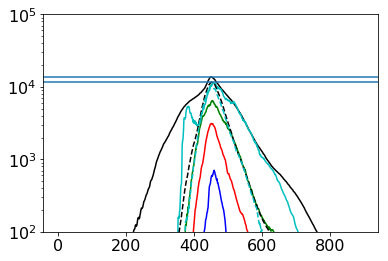

Reading a history file:G:/yeongu//RPS_8pc_ICM1_newacc/hst/RPS_8pc_ICM1_newacc.hst.p
14230.308555290281 17243.674120164298


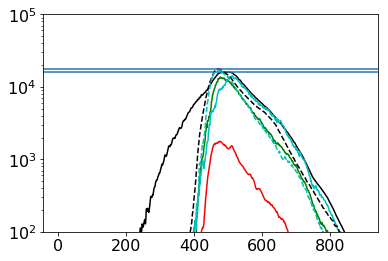

Reading a history file:G:/yeongu//RPS_8pc_ICM2_newacc/hst/RPS_8pc_ICM2_newacc.hst.p
18347.870707918446 14828.285958691451


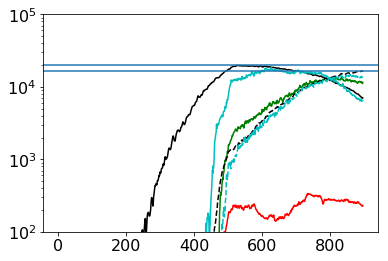

Reading a history file:G:/yeongu//RPS_8pc_ICM3_newacc/hst/RPS_8pc_ICM3_newacc.hst.p
51579.21638249542 0.0


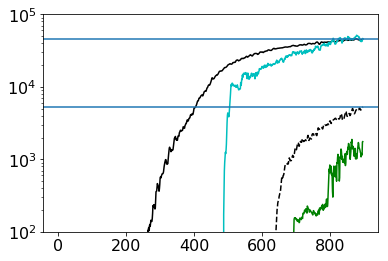

In [97]:
### test pressure #############
import astropy.constants as c
import astropy.units as u
unit=pa.set_units(muH=1.4271)

plt.rcParams['font.size']=16
import os,glob
labels=['noICM_new','ICM1_new','ICM2_new'] # ['no ICM','ICM00','ICM0']#,'ICM00','ICM0',,'ICM2','ICM3','ICM4'
ids=['RPS_8pc_noICM_newacc','RPS_8pc_ICM0_newacc','RPS_8pc_ICM1_newacc','RPS_8pc_ICM2_newacc','RPS_8pc_ICM3_newacc'] # RPS_8pc_ICM00','RPS_8pc_ICM0',,'RPS_8pc_ICM2','RPS_8pc_ICM3','RPS_8pc_ICM4'
#ids=['R8_8pc_metal','RPS_8pc_ICM0','RPS_8pc_ICM1','RPS_8pc_ICM2','RPS_8pc_ICM3']
base='G:/yeongu/'
#base='F:/yeongu/'
#base2='D:/yeongu/'
#C = ('darkkhaki','b','r','k','g','magenta','cyan') # 
C = ('salmon','r','deepskyblue','b','g')
C2 = ('darkblue','deepskyblue','goldenrod','red','firebrick')
hh = [0.006,0.006,0.15]
labell = ('No ICM', 'P3', 'P7')  # r'No ICM',
kb = 1.3806504 * 1e-16 #boltzmann constant erg/K / erg = g cm2/s2
cm = 3.24078*1e-19 # pc
gram = 5.02785*1e-34 # solar mass
#fig =plt.figure(figsize=(7.5,12))
k=1
crit = 94
#plt.figure(figsize=(5,12))
for j,problem_id in enumerate(ids):
    #rstfiles=glob.glob('%s%s/id0/%s.????.rst' % (base,problem_id,problem_id))
    #rstfiles+=glob.glob('%s%s/rst/%s.????.rst' % (base,problem_id,problem_id))
    parfile='{}/{}/{}.par'.format(base,problem_id,problem_id)
    hstfile='{}/{}/hst/{}.hst'.format(base,problem_id,problem_id)
    hst=pa.hst_reader(hstfile)
    #print unit
    Myr=unit['time'].to('Myr').value
    #print unit['density']
    hst.index=hst.time
    hst=hst.loc[250:500,:]
    hst.index=hst.time*Myr
    
    sfr= hst.sfr10
    
    par=pa.get_params(parfile)
    
    Lx=par['x1max']-par['x1min']
    Ly=par['x2max']-par['x2min']
    Lz=par['x3max']-par['x3min']
    
    plist=['phase1','phase2','phase3'] # choose cold unstable warm 
    datasets = xr.Dataset()
    for phase in plist:
        path='{}{}/zprof_merged/{}.{}.zprof.nc'.format(base,problem_id,problem_id,phase)
        with xr.open_dataarray(path) as da: da.load()
        #print da
        datasets[phase]=da
    zprof_ds=datasets
    zprof_ds = zprof_ds.sel(taxis=slice(250,500))
    #zprof_ds = zprof_ds.sel(zaxis=slice(-10,10))
    #print zprof_ds.fields
    #print c.k_B
    Munit=(unit['density']*unit['velocity']*unit['time']).to('Msun/pc^2').value
    #print zprof_ds['phase1'].loc['A'].data.cumsum(), zprof_ds['phase2'].loc['A']
    zprof = zprof_ds.to_array().sum(dim='variable') # three phase sum
    #print zprof.loc['A']
    Area = 1024*1024.#zprof.loc['A']
    tMyr=zprof.taxis*unit['time'].to('Myr').value
    Pok_unit=(unit['pressure']/c.k_B).cgs.value
    Pth=(zprof.loc['P']/Area)*Pok_unit
    Pturb=(2.0*zprof.loc['Ek3']/Area)*Pok_unit
    
    
    oPmag=0.5*(zprof.loc['B1']/Area)**2
    oPmag+=0.5*(zprof.loc['B2']/Area)**2
    oPmag-=0.5*(zprof.loc['B3']/Area)**2
    oPmag=oPmag*Pok_unit
    Tot = Pth+Pturb+oPmag
    #lt.semilogy(np.median(Tot,axis=1))
    #rint np.max(np.median(Tot,axis=1))
    #lt.ylim(1e2,1e5)
    #lt.show()
    
    plt.semilogy(np.nanmedian(Pth,axis=1),c='r')
    plt.semilogy(np.nanmedian(Pturb,axis=1),c='g')
    plt.semilogy(np.nanmedian(oPmag,axis=1),c='b')
    plt.semilogy(np.nanmean(Tot[:,0:crit],axis=1),c='k')
    plt.semilogy(np.nanmedian(Tot[:,0:crit],axis=1),c='c')
    plt.axhline(np.max(np.mean(Tot[:,0:crit],axis=1)))
    plt.semilogy(np.nanmean(Tot[:,crit::],axis=1),c='k',ls='--')
    plt.semilogy(np.nanmedian(Tot[:,crit::],axis=1),c='c',ls='--')
    plt.axhline(np.max(np.mean(Tot[:,crit::],axis=1)))
    #print np.max(np.mean(Tot[:,0:crit],axis=1)),np.max(np.mean(Tot[:,crit::],axis=1))
    print np.max(np.nanmedian(Tot[:,0:crit],axis=1)),np.max(np.nanmedian(Tot[:,crit::],axis=1))
    #plt.axhline(np.max(Tot),ls='--')
    #print Pth[:,t]+Pturb[:,t]+oPmag[:,t]
    #print np.max(Pth[:,t]+Pturb[:,t]+oPmag[:,t])
    plt.ylim(1e2,1e5)
    plt.show()
    '''
    for t in range(50):
        plt.semilogy(Pth[:,t],c='r')
        plt.semilogy(Pturb[:,t],c='g')
        plt.semilogy(oPmag[:,t],c='b')
        plt.semilogy(Tot[:,t],c='k')
        #plt.axhline(np.max(Tot),ls='--')
        print Pth[:,t]+Pturb[:,t]+oPmag[:,t]
        print np.max(Pth[:,t]+Pturb[:,t]+oPmag[:,t])
        plt.ylim(1e2,1e5)
        plt.show()
        plt.close()
    
    '''
    '''
    tPmag=(zprof.loc['dPB1']/zprof.loc['A']).mean(axis=0)
    tPmag+=(zprof.loc['dPB2']/zprof.loc['A']).mean(axis=0)
    tPmag-=(zprof.loc['dPB3']/zprof.loc['A']).mean(axis=0)
    tPmag=tPmag*Pok_unit
    
    plt.rcParams['font.size']=16
    fig=plt.figure(figsize=(10,8))
    plt.plot(tMyr,Pth,label=r'$P_{\rm th}$')
    plt.plot(tMyr,Pturb,label=r'$P_{\rm turb}$')
    plt.plot(tMyr,oPmag,label=r'$\overline{\Pi}_{\rm mag}$')
    plt.plot(tMyr,tPmag,label=r'$\delta{\Pi}_{\rm mag}$')
    lg=plt.legend()
    plt.ylim(1.e2,1.e5)
    plt.yscale('log')
    plt.xlabel('t [Myr]')
    plt.ylabel(r'$P/k_B [{\rm cm^{-3} K}]$')
    plt.show()
    '''
